In [ ]:
!pip install geopandas

In [ ]:
import geopandas as gpd
import pandas as pd
import folium

In [ ]:
from folium import Choropleth, Circle, Marker
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

Merhabalar. Bu Colab Notebook'unda 2019-2020 yıllarına ait Kültür ve Turizm Bakanlığı ve özel kuruluşlara ait müze ve ören yerlerinin verilerini, Marker ve Heat Map gibi haritalandırma yöntemleri ile işleyeceğiz.

In [ ]:
data = pd.read_excel('/content/müze_proje.xlsx')

In [ ]:
data.head()

,Şehirler,KTB Eser Sayısı(2019),KTB Eser Sayısı(2020),KTB Müze Sayısı(2019),KTB Müze Sayısı(2020),KTB Ziyaretçi Sayısı(2019),KTB Ziyaretçi Sayısı(2020),Ören Yeri Sayısı(2019),Ören Yeri Sayısı(2020),Özel Müze Eser Sayısı(2019),Özel Müze Eser Sayısı(2019).1,Özel Müze Sayısı(2019),Özel Müze Sayısı(2020),Özel Müze Ziyaretçi Sayısı(2019),Özel Müze Ziyaretçi Sayısı(2020)
0,Adana-1,52786,52786,3,3,215334,60107,2.0,1.0,321,321,1,1,4300,7298
1,Adıyaman-2,31662,31753,1,1,97378,66908,5.0,5.0,0,0,0,0,0,0
2,Afyonkarahisar-3,49381,49472,1,1,12239,3035,0.0,0.0,1212,990,2,1,2141,502
3,Aksaray-68,16093,16174,1,1,685921,211671,5.0,5.0,0,0,0,0,0,0
4,Amasya-5,22764,22942,3,2,158041,30058,0.0,0.0,733,733,2,2,68418,10691


In [ ]:
data.shape

(81, 15)

In [ ]:
import numpy as np

Hemen alttaki hücrede 'sehir_adi' adında bir dizi oluşturuyoruz ve bu dizinin içeriğini de verimizdeki 'Şehirler' kolonun altında yer alan şehir isimleriyle dolduruyoruz, ardından ise 'split' metodu ile verimizde yer alan örn: Amasya - 5'de de gördüğümüz '-' ifadesini kaldırıp ardından for döngüsü içinde yer alan her 'i' ifadesine(ki bu şehirler oluyor) 'Türkiye' ifadesini ekliyoruz. Bunu yapma sebebimize değineceğim.

In [ ]:
sehir_adi = []
sehir_adi = list(data['Şehirler'])
for ind, i in enumerate(sehir_adi):
  i = i.split('-')[0]  # 0 ---> şehir ismi
  sehir_adi[ind] = i+' Türkiye'

In [ ]:
data['Şehirler'] = sehir_adi

In [ ]:
data.head()

,Şehirler,KTB Eser Sayısı(2019),KTB Eser Sayısı(2020),KTB Müze Sayısı(2019),KTB Müze Sayısı(2020),KTB Ziyaretçi Sayısı(2019),KTB Ziyaretçi Sayısı(2020),Ören Yeri Sayısı(2019),Ören Yeri Sayısı(2020),Özel Müze Eser Sayısı(2019),Özel Müze Eser Sayısı(2019).1,Özel Müze Sayısı(2019),Özel Müze Sayısı(2020),Özel Müze Ziyaretçi Sayısı(2019),Özel Müze Ziyaretçi Sayısı(2020)
0,Adana Türkiye,52786,52786,3,3,215334,60107,2.0,1.0,321,321,1,1,4300,7298
1,Adıyaman Türkiye,31662,31753,1,1,97378,66908,5.0,5.0,0,0,0,0,0,0
2,Afyonkarahisar Türkiye,49381,49472,1,1,12239,3035,0.0,0.0,1212,990,2,1,2141,502
3,Aksaray Türkiye,16093,16174,1,1,685921,211671,5.0,5.0,0,0,0,0,0,0
4,Amasya Türkiye,22764,22942,3,2,158041,30058,0.0,0.0,733,733,2,2,68418,10691


In [ ]:
from geopy.geocoders import Nominatim

'Türkiye' string ifadesini ekleme sebebimiz, geopandas'ın bir tool'u olan geolocator'dan koordinatları daha doğru ve tam olarak çekmemize yaraması. Örneğin ben şehirlerimin sonuna 'Türkiye' eklemeseydim geocoder, Van şehrimizi Fransa'nın Le Van adındaki bir kasabasıyla eşleştirecekti ve onun konum bilgilerini alacaktı.

In [ ]:
geolocator = Nominatim(user_agent='kaggle_learn')
def my_geocoder(row):
    try:
        point = geolocator.geocode(row).point
        return pd.Series({'Latitude': point.latitude, 'Longitude': point.longitude})
    except:
        return None

data[['Latitude', 'Longitude']] = data.apply(lambda x: my_geocoder(x['Şehirler']), axis=1)

print("{}% of addresses were geocoded!".format(
    (1 - sum(np.isnan(data["Latitude"])) / len(data)) * 100))

data = data.loc[~np.isnan(data["Latitude"])]
data = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude))
data.crs = {'init': 'epsg:4326'}
data.head()

100.0% of addresses were geocoded!


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,Şehirler,KTB Eser Sayısı(2019),KTB Eser Sayısı(2020),KTB Müze Sayısı(2019),KTB Müze Sayısı(2020),KTB Ziyaretçi Sayısı(2019),KTB Ziyaretçi Sayısı(2020),Ören Yeri Sayısı(2019),Ören Yeri Sayısı(2020),Özel Müze Eser Sayısı(2019),Özel Müze Eser Sayısı(2019).1,Özel Müze Sayısı(2019),Özel Müze Sayısı(2020),Özel Müze Ziyaretçi Sayısı(2019),Özel Müze Ziyaretçi Sayısı(2020),Latitude,Longitude,geometry
0,Adana Türkiye,52786,52786,3,3,215334,60107,2.0,1.0,321,321,1,1,4300,7298,36.986360,35.325286,POINT (35.32529 36.98636)
1,Adıyaman Türkiye,31662,31753,1,1,97378,66908,5.0,5.0,0,0,0,0,0,0,37.789360,38.314110,POINT (38.31411 37.78936)
2,Afyonkarahisar Türkiye,49381,49472,1,1,12239,3035,0.0,0.0,1212,990,2,1,2141,502,38.685273,30.642741,POINT (30.64274 38.68527)
3,Aksaray Türkiye,16093,16174,1,1,685921,211671,5.0,5.0,0,0,0,0,0,0,38.432629,33.897696,POINT (33.89770 38.43263)
4,Amasya Türkiye,22764,22942,3,2,158041,30058,0.0,0.0,733,733,2,2,68418,10691,40.650325,35.832915,POINT (35.83291 40.65032)


Alttaki hücrede, şehir konumları doğru mu kontrol etmek maksadı ile enlem ve boylam verilerine Marker ekliyorum. len(data['Latitude']) dememin sebebi ise 'Latitude' sütunu altında yer alan satır sayısı kadar işlem yapmam istemem ki bu da 81 ilin tamamını kapsıyor çünkü geolocator az önce gördüğümüz üzere %100 bir oranla şehirlerimize doğru koordinatları vermeyi başardı.

In [ ]:
m_1 = folium.Map(location=[38.963,  35.243], tiles = 'cartodbpositron', zoom_start=5)

for i in range(0, len(data['Latitude'])):
  folium.Marker([data['Latitude'].iloc[i], data['Longitude'].iloc[i]], popup=data['Şehirler'].iloc[i]).add_to(m_1)
m_1

Alttaki hücrede mevcut dataframe ile daha hüçük bir dataframe oluşturma amacım, Marker ikonunun rengini belirleyecek integer değeri ilgili sütundan almak istemem.

In [ ]:
ktb_2020 = data[['Şehirler','KTB Müze Sayısı(2020)']].set_index('Şehirler')
ktb_2020.head()

,KTB Müze Sayısı(2020)
Şehirler,
Adana Türkiye,3
Adıyaman Türkiye,1
Afyonkarahisar Türkiye,1
Aksaray Türkiye,1
Amasya Türkiye,2


Alttaki Marker'lardan oluşan hücrede, amacım Kültür ve Turizm Bakanlığı'na bağlı müze sayılarını bir takım renkler ile kategorize etmekti.

In [ ]:
m_2 = folium.Map(location=[38.963,  35.243], tiles = 'cartodbpositron', zoom_start=5)

def color_producer(val):
  if val == 0:
    return 'purple'
  elif val <= 1:
    return 'green'
  elif val <= 3:
    return 'orange'
  elif val <= 6:
    return 'blue'
  elif val <= 10:
    return 'red'


for i in range(0, len(data['Latitude'])):
  label = '{}, {}'.format(data['Şehirler'].iloc[i], data['KTB Müze Sayısı(2020)'].iloc[i])
  folium.Marker([data['Latitude'].iloc[i], data['Longitude'].iloc[i]], popup=label, icon = folium.Icon(color = color_producer(ktb_2020.iloc[i]['KTB Müze Sayısı(2020)']))).add_to(m_2)
m_2

Hemen ardından bu işlemi özel müze sayıları için de tekrarladım.

In [ ]:
private_2020 = data[['Şehirler','Özel Müze Sayısı(2020)']].set_index('Şehirler')
private_2020.head()

,Özel Müze Sayısı(2020)
Şehirler,
Adana Türkiye,1
Adıyaman Türkiye,0
Afyonkarahisar Türkiye,1
Aksaray Türkiye,0
Amasya Türkiye,2


In [ ]:
m_3 = folium.Map(location=[38.963,  35.243], tiles = 'cartodbpositron', zoom_start=5)

def color_producer(val):
  if val == 0:
    return 'purple'
  elif val <= 1:
    return 'green'
  elif val <= 10:
    return 'orange'
  elif val <= 20:
    return 'blue'
  elif val <= 40:
    return 'red'


for i in range(0, len(data['Latitude'])):
  label = '{}, {}'.format(data['Şehirler'].iloc[i], data['Özel Müze Sayısı(2020)'].iloc[i])
  folium.Marker([data['Latitude'].iloc[i], data['Longitude'].iloc[i]], popup=label, icon = folium.Icon(color = color_producer(private_2020.iloc[i]['Özel Müze Sayısı(2020)']))).add_to(m_3)
m_3

Burada ise Kültür ve Turizm Bakanlığı'na ait müzelere ilgli yılda ziyarette bulunulma sayılarının renklerini Marker'ın üzerinde göstermek için yine başka bir mini dataframe oluşturdum.

In [ ]:
ktb_mis_2020 = data[['Şehirler','KTB Ziyaretçi Sayısı(2020)']].set_index('Şehirler')
ktb_mis_2020.head()

,KTB Ziyaretçi Sayısı(2020)
Şehirler,
Adana Türkiye,60107
Adıyaman Türkiye,66908
Afyonkarahisar Türkiye,3035
Aksaray Türkiye,211671
Amasya Türkiye,30058


In [ ]:
m_4 = folium.Map(location=[38.963,  35.243], tiles = 'cartodbpositron', zoom_start=5)

def color_producer(val):
  if val == 0:
    return 'purple'
  elif val <= 50000:
    return 'green'
  elif val <= 100000:
    return 'orange'
  elif val <= 500000:
    return 'blue'
  elif val <= 1000000:
    return 'red'


for i in range(0, len(data['Latitude'])):
  label = '{}, {}'.format(data['Şehirler'].iloc[i], data['KTB Ziyaretçi Sayısı(2020)'].iloc[i])
  folium.Marker([data['Latitude'].iloc[i], data['Longitude'].iloc[i]], popup=label, icon = folium.Icon(color = color_producer(ktb_mis_2020.iloc[i]['KTB Ziyaretçi Sayısı(2020)']))).add_to(m_4)
m_4

Alttaki hücrede, yine yeni bir dataframe oluşturmak için ana data'dan yararlandım ve içeriğini şehirler, ktb ziyaretçi sayıları(2020 yılı için) ve enlem, boylam sütunları ile doldurdum, ardından index'i şehir olarak belirleyip verimi yazdırdım.



In [ ]:
df_v = data[['Şehirler', 'KTB Ziyaretçi Sayısı(2020)', 'Latitude', 'Longitude']].set_index('Şehirler')
print(df_v)

                        KTB Ziyaretçi Sayısı(2020)   Latitude  Longitude
Şehirler                                                                
Adana Türkiye                                60107  36.986360  35.325286
Adıyaman Türkiye                             66908  37.789360  38.314110
Afyonkarahisar Türkiye                        3035  38.685273  30.642741
Aksaray Türkiye                             211671  38.432629  33.897696
Amasya Türkiye                               30058  40.650325  35.832915
...                                            ...        ...        ...
Çorum Türkiye                                52861  40.569839  34.726929
İstanbul Türkiye                            803386  41.009633  28.965165
İzmir Türkiye                               704776  38.414733  27.143412
Şanlıurfa Türkiye                           270906  37.259520  39.040817
Şırnak Türkiye                                   0  37.455253  42.521205

[81 rows x 3 columns]


Bu hücrede ise ilgili dataframe'in herhangi bir satırında '0' var ise o satırı sildirme komutunu yazdım çünkü oluşturacağım HeatMap aynı zamanda konum bilgisine göre oluşturuluyor ve müze ziyareti olmayan bir şehir olsa bile o şehirde default olarak bir ısı haritası oluşacaktı. Bu kodu yazarak bunu elimine ettim.

In [ ]:
new_df = df_v[df_v.loc[:]!=0].dropna()

Burada ise bunu test etmek için verime son satırlardan bir inceleme yapıyorum. Son olmasının sebebi ise bildiğimiz üzere Şırnak ilinde verimize göre herhangi bir ziyaret olmamış olması. Ve gördüğümüz üzere Şırnak ilinin bulunduğu satır silinmiş.

In [ ]:
new_df.tail()

,KTB Ziyaretçi Sayısı(2020),Latitude,Longitude
Şehirler,,,
Çanakkale Türkiye,230927.0,40.054989,26.927829
Çorum Türkiye,52861.0,40.569839,34.726929
İstanbul Türkiye,803386.0,41.009633,28.965165
İzmir Türkiye,704776.0,38.414733,27.143412
Şanlıurfa Türkiye,270906.0,37.259520,39.040817


Altımızdaki satırda, normalizasyon işlemi yapıyorum. Yapma sebebime gelirsek; harita üzerinde oluşacak Heat Map'in görüntüsünü ayarlamak. Ziyaretçi sayısını 100'e bölünce elde ettiğim görüntü oldukça güzel oldu açıkçası.

In [ ]:
new_df_v = new_df['KTB Ziyaretçi Sayısı(2020)']/10**2
print(new_df_v)

Şehirler
Adana Türkiye              601.07
Adıyaman Türkiye           669.08
Afyonkarahisar Türkiye      30.35
Aksaray Türkiye           2116.71
Amasya Türkiye             300.58
                           ...   
Çanakkale Türkiye         2309.27
Çorum Türkiye              528.61
İstanbul Türkiye          8033.86
İzmir Türkiye             7047.76
Şanlıurfa Türkiye         2709.06
Name: KTB Ziyaretçi Sayısı(2020), Length: 65, dtype: float64


Heat Map'i oluştururken, sunumda da anlattığımız üzere verimizdeki herhangi bir satırın enlem ve boylam bilgilerinden yararlanıyoruz. Fakat benim elimde bulunan veride(new_df) indexler şehirlerden oluşuyor ama her şehir sadece bir satırda yer alıyor. Müze sayıları her şehir için tek bir satırda yer alıyor ve haliyle elimizde tek bir lokasyon bilgisi yer almış oluyor ve bu da şehirin kendi lokasyonu. Bu durumu lehimize çevirmek için de oluşturduğumuz dataframe'e ziyaretçi sayısı bilgisinin tutulduğu sütunu da ekliyoruz ve böylelikle 3 sütunluk bir verimiz oluyor. Bu veriyi de diziye çeviriyoruz zira folium, Heat Map'i dizilerle oluşturabiliyor, dataframe ile değil. (3.sütuna katsayı diyebiliriz.)

In [ ]:
data_1 = new_df[['Latitude', 'Longitude']]
data_1['KTB Ziyaretçi Sayısı(2020)'] = new_df_v
data_1 = data_1.to_numpy()

m_5 = folium.Map(location=[38.963,  35.243], tiles='cartodbpositron', zoom_start=6)
HeatMap(data=data_1, radius=30).add_to(m_5)
m_5

In [ ]:
print(data_1)

[[3.69863599e+01 3.53252861e+01 6.01070000e+02]
 [3.77893600e+01 3.83141101e+01 6.69080000e+02]
 [3.86852729e+01 3.06427411e+01 3.03500000e+01]
 [3.84326291e+01 3.38976963e+01 2.11671000e+03]
 [4.06503248e+01 3.58329148e+01 3.00580000e+02]
 [3.99207886e+01 3.28540482e+01 1.80518000e+03]
 [3.69009641e+01 3.06954846e+01 1.34911100e+04]
 [3.78483767e+01 2.78435878e+01 1.34255000e+03]
 [3.95291600e+01 4.33835645e+01 8.35950000e+02]
 [3.95400798e+01 2.80228793e+01 2.47850000e+02]
 [4.14947715e+01 3.24354255e+01 1.04970000e+02]
 [3.77874104e+01 4.12573924e+01 2.38700000e+01]
 [4.01435101e+01 2.99752911e+01 1.25650000e+02]
 [3.84950867e+01 4.21678372e+01 3.35740000e+02]
 [4.06212099e+01 3.16460259e+01 2.94200000e+01]
 [3.75183407e+01 3.01691254e+01 5.05960000e+02]
 [4.01827657e+01 2.90677305e+01 4.65130000e+02]
 [3.77733197e+01 2.90869273e+01 7.28665000e+03]
 [3.79162222e+01 4.02363542e+01 7.84540000e+02]
 [4.08774545e+01 3.12009618e+01 4.06300000e+01]
 [4.16759327e+01 2.65587225e+01 2.845200

Yine aynı şekilde pop-up için ana datamızın içinden yeni bir dataframe oluşturdum.

In [ ]:
ktb_mis_2019 = data[['Şehirler','KTB Ziyaretçi Sayısı(2019)']].set_index('Şehirler')
ktb_mis_2019.head()

,KTB Ziyaretçi Sayısı(2019)
Şehirler,
Adana Türkiye,215334
Adıyaman Türkiye,97378
Afyonkarahisar Türkiye,12239
Aksaray Türkiye,685921
Amasya Türkiye,158041


In [ ]:
m_4 = folium.Map(location=[38.963,  35.243], tiles = 'cartodbpositron', zoom_start=5)

def color_producer(val):
  if val == 0:
    return 'purple'
  elif val <= 50000:
    return 'green'
  elif val <= 100000:
    return 'orange'
  elif val <= 500000:
    return 'blue'
  elif val <= 1000000:
    return 'red'


for i in range(0, len(data['Latitude'])):
  label = '{}, {}'.format(data['Şehirler'].iloc[i], data['KTB Ziyaretçi Sayısı(2019)'].iloc[i])
  folium.Marker([data['Latitude'].iloc[i], data['Longitude'].iloc[i]], popup=label, icon = folium.Icon(color = color_producer(ktb_mis_2019.iloc[i]['KTB Ziyaretçi Sayısı(2019)']))).add_to(m_4)
m_4

In [ ]:
df_v2 = data[['Şehirler', 'KTB Ziyaretçi Sayısı(2019)', 'Latitude', 'Longitude']].set_index('Şehirler')
print(df_v2)

                        KTB Ziyaretçi Sayısı(2019)   Latitude  Longitude
Şehirler                                                                
Adana Türkiye                               215334  36.986360  35.325286
Adıyaman Türkiye                             97378  37.789360  38.314110
Afyonkarahisar Türkiye                       12239  38.685273  30.642741
Aksaray Türkiye                             685921  38.432629  33.897696
Amasya Türkiye                              158041  40.650325  35.832915
...                                            ...        ...        ...
Çorum Türkiye                               123133  40.569839  34.726929
İstanbul Türkiye                           7798283  41.009633  28.965165
İzmir Türkiye                              3059225  38.414733  27.143412
Şanlıurfa Türkiye                           729966  37.259520  39.040817
Şırnak Türkiye                                   0  37.455253  42.521205

[81 rows x 3 columns]


In [ ]:
new_df2 = df_v2[df_v2.loc[:]!=0].dropna()

In [ ]:
new_df2.tail()

,KTB Ziyaretçi Sayısı(2019),Latitude,Longitude
Şehirler,,,
Çankırı Türkiye,15125.0,40.666769,33.452607
Çorum Türkiye,123133.0,40.569839,34.726929
İstanbul Türkiye,7798283.0,41.009633,28.965165
İzmir Türkiye,3059225.0,38.414733,27.143412
Şanlıurfa Türkiye,729966.0,37.259520,39.040817


In [ ]:
new_df_v2 = new_df2['KTB Ziyaretçi Sayısı(2019)']/10**2
print(new_df_v2)

Şehirler
Adana Türkiye              2153.34
Adıyaman Türkiye            973.78
Afyonkarahisar Türkiye      122.39
Aksaray Türkiye            6859.21
Amasya Türkiye             1580.41
                            ...   
Çankırı Türkiye             151.25
Çorum Türkiye              1231.33
İstanbul Türkiye          77982.83
İzmir Türkiye             30592.25
Şanlıurfa Türkiye          7299.66
Name: KTB Ziyaretçi Sayısı(2019), Length: 64, dtype: float64


In [ ]:
data_2 = new_df2[['Latitude', 'Longitude']]
data_2['KTB Ziyaretçi Sayısı(2019)'] = new_df_v2
data_2 = data_2.to_numpy()

m_5 = folium.Map(location=[38.963,  35.243], tiles='cartodbpositron', zoom_start=6)
HeatMap(data=data_2, radius=30).add_to(m_5)
m_5

Aşağıdaki resimde gördüğümüz karşılaştırma, 2019 ve 2020 yılları içinde Kültür ve Turizm Bakanlığı'na bağlı müzelere yapılan ziyaretlerin ısı haritasını içeriyor ve görselden çıkarabileceğimiz en temel yorum, Covid-19 sebebi ile 2020 yılının pandemi döneminde geçmesi ve buna bağlı olarak müzelere ziyarette ciddi derecede bir düşüş olmuş olmasını gösterebiliriz.

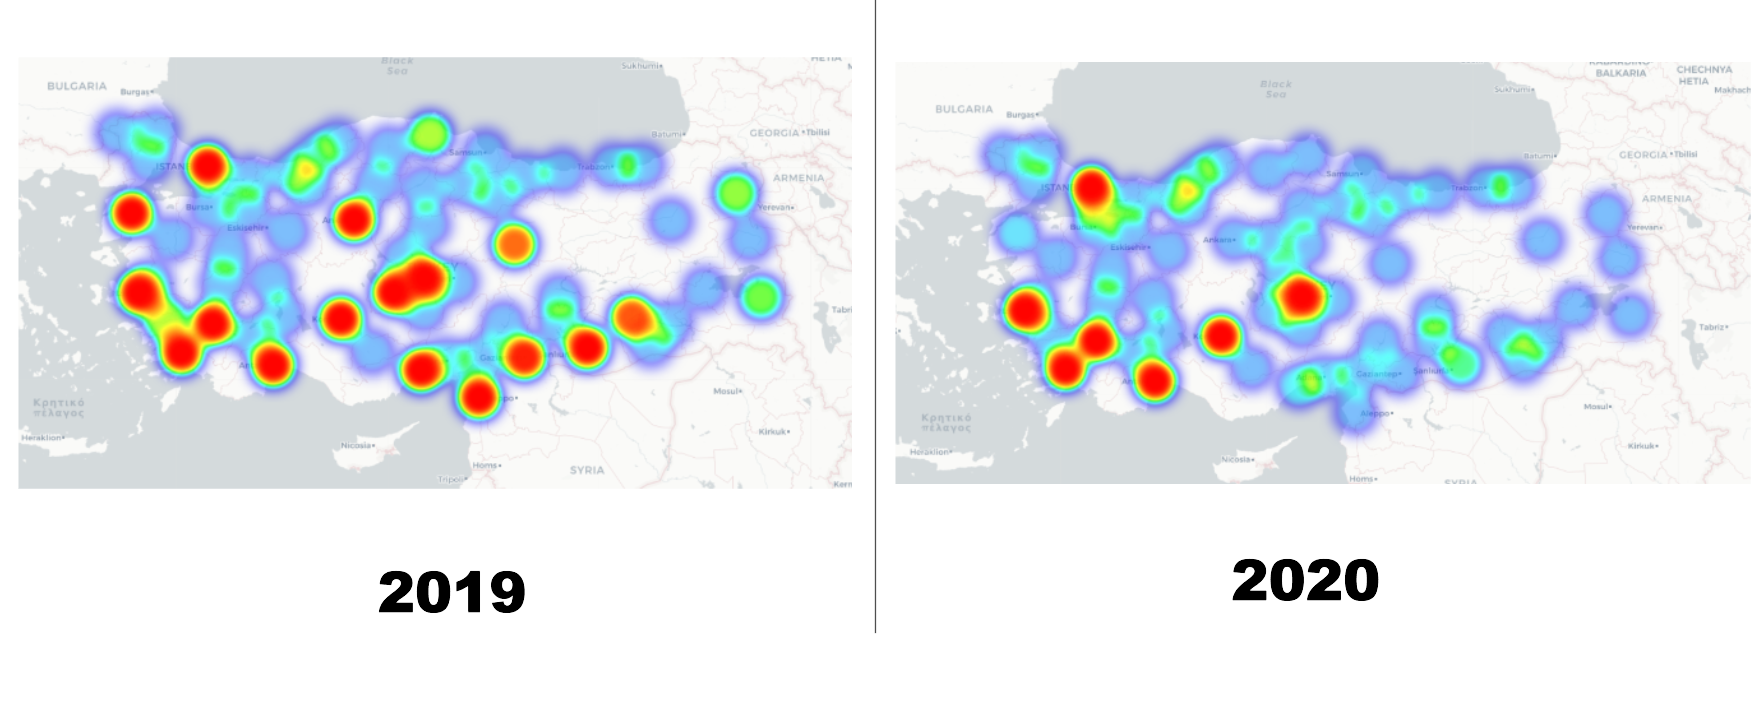

In [ ]:
private_mis_2020 = data[['Şehirler','Özel Müze Ziyaretçi Sayısı(2020)']].set_index('Şehirler')
private_mis_2020.head()

,Özel Müze Ziyaretçi Sayısı(2020)
Şehirler,
Adana Türkiye,7298
Adıyaman Türkiye,0
Afyonkarahisar Türkiye,502
Aksaray Türkiye,0
Amasya Türkiye,10691


In [ ]:
m_6 = folium.Map(location=[38.963,  35.243], tiles = 'cartodbpositron', zoom_start=5)

def color_producer(val):
  if val == 0:
    return 'purple'
  elif val <= 50000:
    return 'green'
  elif val <= 100000:
    return 'orange'
  elif val <= 500000:
    return 'blue'
  elif val <= 1000000:
    return 'red'


for i in range(0, len(data['Latitude'])):
  label = '{}, {}'.format(data['Şehirler'].iloc[i], data['Özel Müze Ziyaretçi Sayısı(2020)'].iloc[i])
  folium.Marker([data['Latitude'].iloc[i], data['Longitude'].iloc[i]], popup=label, icon = folium.Icon(color = color_producer(private_mis_2020.iloc[i]['Özel Müze Ziyaretçi Sayısı(2020)']))).add_to(m_6)
m_6

In [ ]:
df_pv = data[['Şehirler', 'Özel Müze Ziyaretçi Sayısı(2020)', 'Latitude', 'Longitude']].set_index('Şehirler')
print(df_pv)

                        Özel Müze Ziyaretçi Sayısı(2020)   Latitude  Longitude
Şehirler                                                                      
Adana Türkiye                                       7298  36.986360  35.325286
Adıyaman Türkiye                                       0  37.789360  38.314110
Afyonkarahisar Türkiye                               502  38.685273  30.642741
Aksaray Türkiye                                        0  38.432629  33.897696
Amasya Türkiye                                     10691  40.650325  35.832915
...                                                  ...        ...        ...
Çorum Türkiye                                          0  40.569839  34.726929
İstanbul Türkiye                                 1640471  41.009633  28.965165
İzmir Türkiye                                     106424  38.414733  27.143412
Şanlıurfa Türkiye                                  25240  37.259520  39.040817
Şırnak Türkiye                                      

In [ ]:
new_df1 = df_pv[df_pv.loc[:]!=0].dropna()

In [ ]:
new_df1.tail()

,Özel Müze Ziyaretçi Sayısı(2020),Latitude,Longitude
Şehirler,,,
Yalova Türkiye,12297.0,40.592707,29.077136
Çanakkale Türkiye,24728.0,40.054989,26.927829
İstanbul Türkiye,1640471.0,41.009633,28.965165
İzmir Türkiye,106424.0,38.414733,27.143412
Şanlıurfa Türkiye,25240.0,37.259520,39.040817


In [ ]:
new_df_pv = new_df1['Özel Müze Ziyaretçi Sayısı(2020)']/10**2
print(new_df_pv)

Şehirler
Adana Türkiye                72.98
Afyonkarahisar Türkiye        5.02
Amasya Türkiye              106.91
Ankara Türkiye             5426.83
Antalya Türkiye             351.40
Aydın Türkiye               109.57
Balıkesir Türkiye           836.18
Bartın Türkiye               67.36
Bayburt Türkiye             186.84
Bilecik Türkiye             113.28
Bursa Türkiye              3802.57
Denizli Türkiye               6.17
Diyarbakır Türkiye          162.62
Düzce Türkiye                 1.32
Edirne Türkiye             2052.55
Erzincan Türkiye            102.00
Erzurum Türkiye               8.20
Eskişehir Türkiye          2537.83
Gaziantep Türkiye          1974.31
Isparta Türkiye             119.33
Kahramanmaraş Türkiye        29.60
Karabük Türkiye             132.44
Kastamonu Türkiye           352.34
Kayseri Türkiye             331.97
Kocaeli Türkiye             584.05
Konya Türkiye              1191.75
Kütahya Türkiye             157.34
Kırklareli Türkiye            0.20
Kırıkkale T

In [ ]:
data_3 = new_df1[['Latitude', 'Longitude']]
data_3['Özel Müze Ziyaretçi Sayısı(2020)'] = new_df_pv
data_3 = data_3.to_numpy()

m_7 = folium.Map(location=[38.963,  35.243], tiles='cartodbpositron', zoom_start=6)
HeatMap(data=data_3, radius=30).add_to(m_7)
m_7

In [ ]:
df_pv2 = data[['Şehirler', 'Özel Müze Ziyaretçi Sayısı(2019)', 'Latitude', 'Longitude']].set_index('Şehirler')
print(df_pv2)

                        Özel Müze Ziyaretçi Sayısı(2019)   Latitude  Longitude
Şehirler                                                                      
Adana Türkiye                                       4300  36.986360  35.325286
Adıyaman Türkiye                                       0  37.789360  38.314110
Afyonkarahisar Türkiye                              2141  38.685273  30.642741
Aksaray Türkiye                                        0  38.432629  33.897696
Amasya Türkiye                                     68418  40.650325  35.832915
...                                                  ...        ...        ...
Çorum Türkiye                                          0  40.569839  34.726929
İstanbul Türkiye                                 5930711  41.009633  28.965165
İzmir Türkiye                                     312073  38.414733  27.143412
Şanlıurfa Türkiye                                  39613  37.259520  39.040817
Şırnak Türkiye                                      

In [ ]:
new_df3 = df_pv2[df_pv2.loc[:]!=0].dropna()

In [ ]:
new_df3.tail()

,Özel Müze Ziyaretçi Sayısı(2019),Latitude,Longitude
Şehirler,,,
Zonguldak Türkiye,45100.0,41.250324,31.838974
Çanakkale Türkiye,93778.0,40.054989,26.927829
İstanbul Türkiye,5930711.0,41.009633,28.965165
İzmir Türkiye,312073.0,38.414733,27.143412
Şanlıurfa Türkiye,39613.0,37.259520,39.040817


In [ ]:
new_df_pv2 = new_df3['Özel Müze Ziyaretçi Sayısı(2019)']/10**2
print(new_df_pv2)

Şehirler
Adana Türkiye                43.00
Afyonkarahisar Türkiye       21.41
Amasya Türkiye              684.18
Ankara Türkiye            16542.70
Antalya Türkiye            1412.32
Aydın Türkiye               295.14
Balıkesir Türkiye          1636.68
Bartın Türkiye               19.41
Bayburt Türkiye             210.00
Bilecik Türkiye             508.95
Bursa Türkiye             22259.11
Denizli Türkiye              13.77
Diyarbakır Türkiye          478.75
Düzce Türkiye                 8.28
Edirne Türkiye             6928.19
Erzincan Türkiye            198.50
Erzurum Türkiye              52.00
Eskişehir Türkiye         10769.41
Gaziantep Türkiye          8776.96
Kahramanmaraş Türkiye        72.00
Karabük Türkiye             326.99
Kastamonu Türkiye          2778.65
Kayseri Türkiye            1340.97
Kocaeli Türkiye            1277.21
Konya Türkiye              2947.62
Kütahya Türkiye             971.66
Kırklareli Türkiye            3.82
Kırıkkale Türkiye            41.00
Malatya Tür

In [ ]:
data_4 = new_df3[['Latitude', 'Longitude']]
data_4['Özel Müze Ziyaretçi Sayısı(2019)'] = new_df_pv2
data_4 = data_4.to_numpy()

m_7 = folium.Map(location=[38.963,  35.243], tiles='cartodbpositron', zoom_start=6)
HeatMap(data=data_4, radius=30).add_to(m_7)
m_7

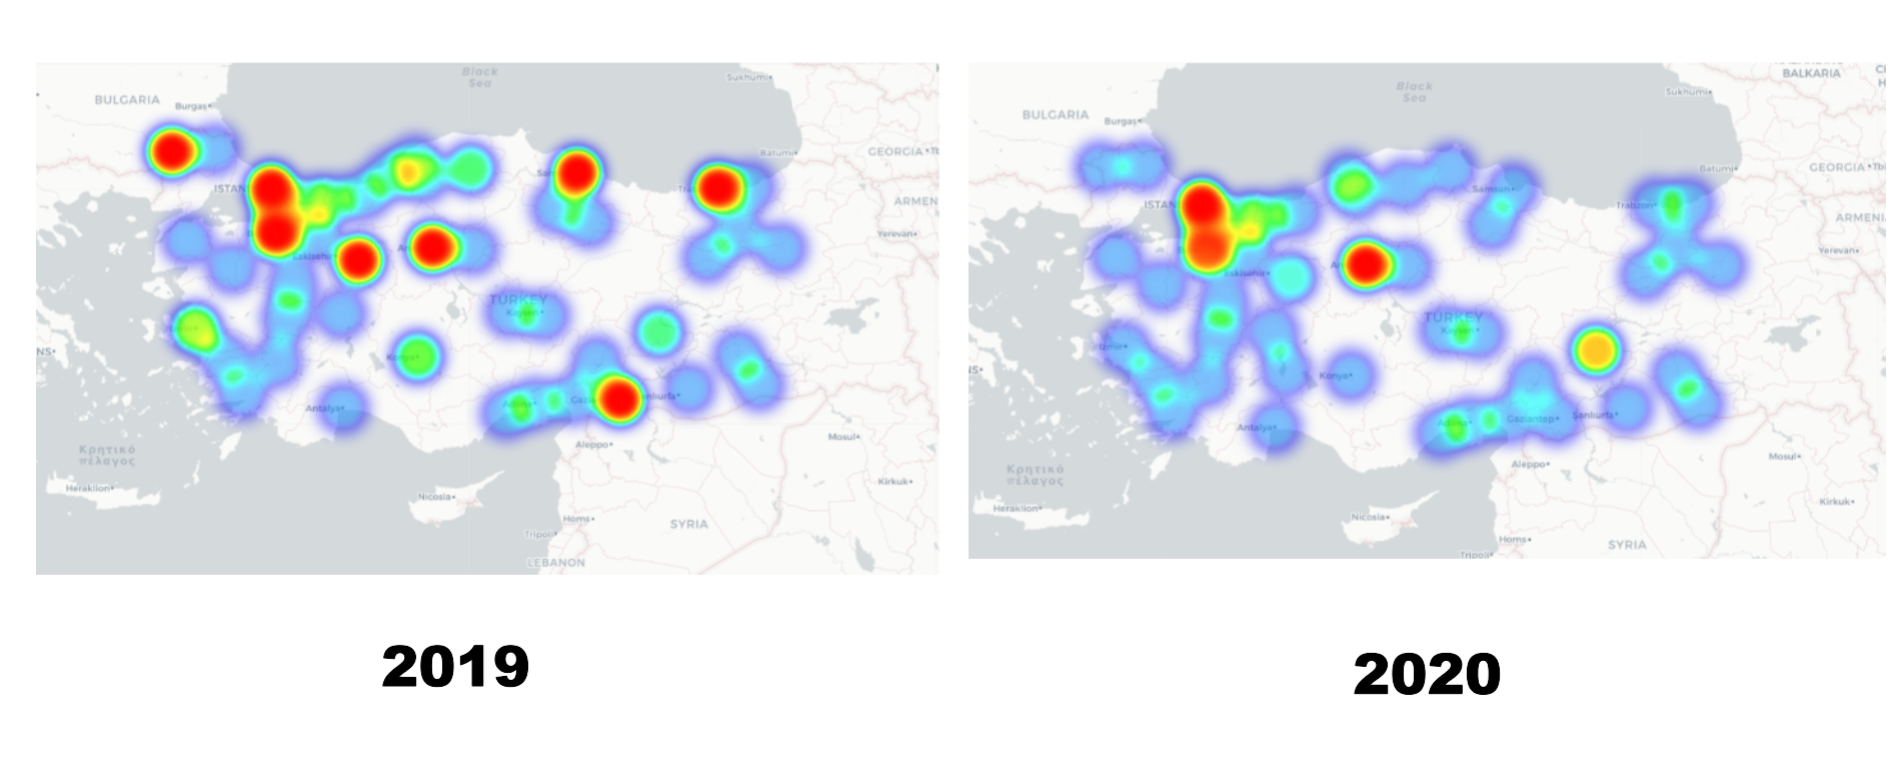

In [ ]:
oys_2020 = data[['Şehirler','Ören Yeri Sayısı(2020)']].set_index('Şehirler')
oys_2020.head()

,Ören Yeri Sayısı(2020)
Şehirler,
Adana Türkiye,1.0
Adıyaman Türkiye,5.0
Afyonkarahisar Türkiye,0.0
Aksaray Türkiye,5.0
Amasya Türkiye,0.0


In [ ]:
m_7 = folium.Map(location=[38.963,  35.243], tiles = 'cartodbpositron', zoom_start=5)

def color_producer(val):
  if val == 0:
    return 'purple'
  elif val <= 1:
    return 'green'
  elif val <= 5:
    return 'orange'
  elif val <= 10:
    return 'blue'
  elif val <= 15:
    return 'red'


for i in range(0, len(data['Latitude'])):
  label = '{}, {}'.format(data['Şehirler'].iloc[i], data['Ören Yeri Sayısı(2020)'].iloc[i])
  folium.Marker([data['Latitude'].iloc[i], data['Longitude'].iloc[i]], popup=label, icon = folium.Icon(color = color_producer(oys_2020.iloc[i]['Ören Yeri Sayısı(2020)']))).add_to(m_7)
m_7

In [ ]:
oys_2019 = data[['Şehirler','Ören Yeri Sayısı(2019)']].set_index('Şehirler')
oys_2019.head()

,Ören Yeri Sayısı(2019)
Şehirler,
Adana Türkiye,2.0
Adıyaman Türkiye,5.0
Afyonkarahisar Türkiye,0.0
Aksaray Türkiye,5.0
Amasya Türkiye,0.0


In [ ]:
m_8 = folium.Map(location=[38.963,  35.243], tiles = 'cartodbpositron', zoom_start=5)

def color_producer(val):
  if val == 0:
    return 'purple'
  elif val <= 1:
    return 'green'
  elif val <= 5:
    return 'orange'
  elif val <= 10:
    return 'blue'
  elif val <= 15:
    return 'red'


for i in range(0, len(data['Latitude'])):
  label = '{}, {}'.format(data['Şehirler'].iloc[i], data['Ören Yeri Sayısı(2019)'].iloc[i])
  folium.Marker([data['Latitude'].iloc[i], data['Longitude'].iloc[i]], popup=label, icon = folium.Icon(color = color_producer(oys_2019.iloc[i]['Ören Yeri Sayısı(2019)']))).add_to(m_8)
m_8